# Piston expander

This example explains how to use properly PDSim to simulate a piston expander. The same methodology can be readily applied to other positive displacement machines.  

In [1]:
## COMMON IMPORTS ##
from __future__ import division, print_function
from math import pi, cos, sin
from timeit import default_timer
import os, sys
import matplotlib.pyplot as plt, numpy as np
%matplotlib inline

In [2]:
#From PDSim we import the different elements that allows us to built a positive displacement simulation code.
from PDSim.flow.flow import FlowPath
from PDSim.flow import flow_models
from PDSim.misc.datatypes import empty_arraym
from PDSim.core.containers import ControlVolume, Tube
from PDSim.core.core import PDSimCore


In [3]:
# We need also to import CoolProp as property library to define suction and discharge states of the expander 
# (or compressor).
from CoolProp import State
from CoolProp import CoolProp as CP

In [4]:
# We create a class derived from PDSimCore that holds the piston expander model

class PistonExpander(PDSimCore):
    
    #: Displacement of the cylinder above the dead volume [m^3]
    Vdisp = 20e-6
    
    #: Dead volume of the cylinder at TDC [m^3]
    Vdead = 3e-6
    
    #: Rotational speed [rad/s]
    omega = 377
    
    def __init__(self):
        #Initialize the base class that PistonExpander is derived from
        PDSimCore.__init__(self)

    # We define the working chamber volume as function of the crank angle and its derivative. 
    # In this case we assume a simplified mathematical formulation 
    def V_dV(self, theta):
        
        V = self.Vdead+self.Vdisp/2*(1-cos(theta))
        dVdtheta = self.Vdisp/2*sin(theta)
        return V, dVdtheta

    # We define the suction and discharge port area profiles as well as the flow model through such ports.
    def Suction(self, FlowPath):
        if 0 <= self.theta <= pi/4:
            FlowPath.A = pi*0.006**2/4*(1-cos(8*self.theta))/2
            mdot = flow_models.IsentropicNozzle(FlowPath.A,
                                                FlowPath.State_up,
                                                FlowPath.State_down)
        else:
            FlowPath.A = 0.0
            mdot = 0
        return mdot
        
    def Discharge(self, FlowPath):
        if pi <= self.theta <= 7*pi/4:
            FlowPath.A = pi*0.006**2/4*(1-cos(4*self.theta))/2
            mdot = flow_models.IsentropicNozzle(FlowPath.A,
                                            FlowPath.State_up,
                                            FlowPath.State_down)
        else:
            FlowPath.A = 0.0
            mdot = 0
        return mdot

    # We define a tube flow model to connect the inlet of the expander shell with the actual suction port. 
    # Similar model is applied on the discharge side. 
    def TubeCode(self, Tube):

        Tube.Q = flow_models.IsothermalWallTube(Tube.mdot, 
                                                Tube.State1, 
                                                Tube.State2,
                                                Tube.fixed, 
                                                Tube.L, 
                                                Tube.ID,
                                                T_wall = self.Tlumps[0])

    # In this case we neglect the in-chamber heat transfer which eventually can be added 
    # depending on the type of machine
    def heat_transfer_callback(self, theta):
        return empty_arraym(self.CVs.N)

    # We also neglect the mechanical losses for simplicity
    def mechanical_losses(self):
        return 0

    # We define the heat transfer between the expander shell and the ambient by defining 
    # a constant heat transfer coefficient
    def ambient_heat_transfer(self):
        return self.h_shell*self.A_shell*(self.Tamb-self.Tlumps[0]) #[kW]

    # At this point we are able to define an overall energy balance of the expander shell 
    # with a single lumped temperature
    def lump_energy_balance_callback(self):

        #Mechanical losses are added to the lump
        self.Wdot_mechanical = self.mechanical_losses() #[kW]
        #Heat transfer between the shell and the ambient
        self.Qamb = self.ambient_heat_transfer() #[kW]
        return self.Wdot_mechanical + self.Qamb

    # Callback function for the stepsize of the solver
    def step_callback(self,theta,h,Itheta):
        self.theta = theta
        return False, h

In [5]:
# We have completely defined the class that hold the general piston expander model. 
# Now we can actually define a function to run the model
def Expander():

    expander = PistonExpander() #Instantiate the class

    # We specify the working fluid, the inlet state conditions (temperature and pressure in this case), 
    # the outlet state for which the the pressure is specified and the temperature is guessed. 
    # Last, we need to provide a guess for the inlet mass flow rate. The model calculate the actual 
    # mass flow rate through the machine as well as the discharge temperature.
    Ref = 'Nitrogen'
    inletState = State.State(Ref,dict(T = 298.15, P = 501.325))
    outletState = State.State(Ref,dict(T = 200, P = inletState.p/10))
    mdot_guess = inletState.rho*expander.Vdisp*expander.omega/(2*pi)

    # The piston expander has only one working chamber and therefore we add one control volume
    expander.add_CV(ControlVolume(key='A',
                                  initialState=inletState.copy(),
                                  VdVFcn=expander.V_dV,)
                    )

    # We define the necessary constants for ambient heat transfer
    expander.h_shell = 0.010               #[kW/m2/K]
    expander.A_shell = pi*10*2*(0.0254**2) #[m2]
    expander.Tamb = 298                    #[K]
    expander.Wdot_parasitic = 0.01         #Parasitic losses [kW]

    """
    We add the inlet and outlet tubes. The states of the tube are defines as:
        
            inlet tube:
            __________________
     inlet.1                    inlet.2  
            __________________


            outlet tube:
            __________________
    outlet.2                   outlet.1  
            __________________  
    """
    #Add the inlet tube
    expander.add_tube(Tube(key1 = 'inlet.1',
                           key2 = 'inlet.2',
                           L = 0.03,
                           ID = 0.01,
                           mdot = mdot_guess, 
                           State1 = inletState.copy(),
                           fixed = 1,
                           TubeFcn = expander.TubeCode) 
                      )
    
    #Add the outlet tube
    expander.add_tube(Tube(key1 = 'outlet.1',
                           key2 = 'outlet.2',
                           L = 0.03,
                           ID = 0.01,
                           mdot = mdot_guess, 
                           State2 = outletState.copy(),
                           fixed = 2,
                           TubeFcn = expander.TubeCode) 
                      )

    # We define flow paths to connect the nodes of the tubes with the suction or discharge states 
    expander.add_flow(FlowPath(key1='inlet.2',key2='A',MdotFcn=expander.Suction))
    expander.add_flow(FlowPath(key1='outlet.1',key2='A',MdotFcn=expander.Discharge))

    # We connect together the energy balance of the expander shell
    t1=default_timer()
    expander.connect_callbacks(step_callback = expander.step_callback,
                               endcycle_callback=expander.endcycle_callback, # Provided by PDSimCore
                               heat_transfer_callback=expander.heat_transfer_callback,
                               lumps_energy_balance_callback = expander.lump_energy_balance_callback)    

    # We choose the solver and the integration options
    expander.EulerN = 5000
    expander.solve(key_inlet='inlet.1',
                   key_outlet='outlet.2',
                   solver_method = 'Euler',
                   OneCycle = False,
                   eps_cycle = 1e-10,
                   UseNR = True,
                   plot_every_cycle = False,
                   eps_energy_balance = 1e-3
                   )

    print('time taken',default_timer()-t1,'s')

    return expander
    

Elapsed time for cycle is 0.745907 s
new outlet T 200.0
|| # 000 ||
||.............|..........@.........................|| energy balance kW  0.0397258663612  Tlumps:  [201.35118811149215] K
||.............|.......................@............|| discharge state 2.09678044086 h_pump_set:  186.277460765 kJ/kg 207.245265174 kJ/kg
||.............|...................@................|| cycle-cycle     0.623900308467
||..................................|............@..|| mdot [%] 60.7758205466 || in: 0.622516084475 g/s || out: 1.00085534285 g/s 
Elapsed time for cycle is 0.859858 s
new outlet T 200.0
|| # 001 ||
||.............|..........@.........................|| energy balance kW  0.0391781406638  Tlumps:  [269.005356433448] K
||.............|......................@.............|| discharge state 1.76899659402 h_pump_set:  189.485665291 kJ/kg 207.175631231 kJ/kg
||.............|..........@.........................|| cycle-cycle     0.0335523453722
||..................................|.@.

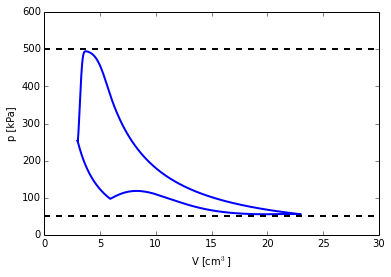

In [6]:
#Finally, we can run the piston expander model and have access to the variables for plotting
piston = Expander()

#We plot out the PV diagram
p = piston.p.T     #[kPa] 
V = piston.V.T*1e6 #[cm^3]

plt.plot(V,p, 'b-',lw = 2)
plt.plot([0,100],[piston.inlet_state.p,piston.inlet_state.p],'k--',lw = 2)
plt.plot([0,100],[piston.outlet_state.p,piston.outlet_state.p],'k--',lw = 2)
plt.xlabel(r'V [cm$^3$]',fontsize = 10)
plt.ylabel(r'p [kPa]',fontsize = 10)
plt.xlim(0,30)
lb = plt.ylim(0,600)
